# DRL Homework 03

### 1 Homework Review

This week we reviewed group 4 and group 17 during the online Q&A session with Reem Farah. Here is a [link to our notes on their homework 2 submissions](https://docs.google.com/document/d/1FyHsLY0v6WyM0XfMx1w9Lu9cv9877figL6aZavpiyGE/edit?usp=sharing). 

### 2 Learning a policy via 1-step SARSA
For the following work again work with your own gridworld implementation! You may revise/change pieces of it, or ask other groups for access to their implementation of course.
* Implement tabular 1-step SARSA control
* Measure average Return-per-Episode and plot it against (1) episodes sampled, and (2) wallclock-time

For an outstanding submission:

* Visualize the State-Action Values in your gridworld during training at regular intervals, and provide a visualization of them (e.g. a series of images, best combine them into a short video clip)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

# Directions as a faux enum, this is the set A of actions
UP = 0
LEFT = 1
DOWN = 2
RIGHT = 3
DIRECTIONS = [UP, LEFT, DOWN, RIGHT]
DIRECTION_TO_SYMBOL = {UP:"↑", LEFT:"←", DOWN:"↓", RIGHT:"→", "EMPTY":"█"}

class State:

    def __init__(self, row, col):
        self.row = row
        self.col = col

    def __eq__(self, other):
        return self.row == other.row and self.col == other.col
    
    def __repr__(self):
        return f"({self.row}, {self.col})"

def distance_between_states(state_1: State, state_2: State) -> int:
    """Calculate Manhattan distance between states. This is useful for the 
       agent's policy, but also useful for positioning walls are warps away 
       from the start and end state."""
    return abs(state_2.row - state_1.row) + abs(state_2.col - state_1.col)
    
def direction_arithmetic(curr_pos: State, direction: int) -> State:
    """Calculate the resulting state coordinates given a state and direction."""
    row, col = curr_pos.row, curr_pos.col
    if direction == UP:
        row = row - 1
    elif direction == LEFT:
        col = col - 1
    elif direction == DOWN:
        row = row + 1
    elif direction == RIGHT:
        col = col + 1
    else:
        raise Exception(f"Unrecognized direction: {direction}")
    return State(row, col)

def average(l):
    if l:
        return sum(l)/len(l)
    else:
        return 0
    
def argmax(d):
    
    """ get index matched lists of actions and values for d """
    actions = list(d.keys())
    values = list(d.values())
    
    try:
        max_val = max(values)
    except ValueError:
        return "EMPTY"
    
    max_actions = []
    
    for i in range(len(values)):
        if values[i] == max_val:
            max_actions.append(actions[i])
            
    return random.choice(max_actions)
       

def print_matrix(m):
    for row in m:
        for col in row:
            print(f"{col:.3f}", end='\t')
        print()
        

def print_policy_from_q(q):
    """ prints the policy from q, where the policy takes the action with the
        best Q value for a given state"""
    print(grid_to_ascii(q, lambda cell : DIRECTION_TO_SYMBOL[argmax(cell)]))
    
def grid_to_ascii(grid, transformation=str):
    s = ""
    height = len(grid)
    width = len(grid[0])
    for row in range(height):
        s += "==" * (width) + "="
        s += "\n"
        for col in range(width):
            s += f"|{transformation(grid[row][col])}"
        s +="|\n"
    s += "==" * (width) + "="
    return s
    

def max_q(Q):
    """ return a widthxheight array of the maximum returns for each gridcell
        in Q and a widthxheight array of the best actions """
    width = len(Q)
    height = len(Q[0])
    
    values = [[ float("-inf") for _ in range(width)] for _ in range(height)] 
    actions = [[ [] for _ in range(width)] for _ in range(height)] 
    
    for x in range(width):
        for y in range(height):
            cell_returns = Q[x][y]
            if cell_returns:
                max_action = max(cell_returns, key= lambda x: cell_returns[x])
                max_return = cell_returns[max_action]
            
                values[x][y] = max_return
                actions[x][y] = max_action
            
    return (values, actions)

#### Agent Classes

In [2]:
class Agent:
    """This base agent class just takes random actions."""
    
    def __init__(self, state=State(0, 0)):
        self.state = state
        self.available_actions = []
        self.available_next_states = []
        
    def get_action_from_policy(self):
        return random.choice(self.available_actions)
    
    def take_action(self, action):
        action_index = self.available_action.index(action)
        self.state = self.available_next_states[action_index]
        
    def reset(self, state=State(0, 0)):
        self.state = state
        self.available_actions = []
        self.available_next_states = []
        
class MagneticAgent(Agent):
    """The MagneticAgent likes to choose actions that bring it closer
       to the win state, regardless of what obstacles are in the way."""

    def __init__(self, win_state=State(0, 0), start_state=State(0, 0)):
        self.state = start_state
        self.win_state = win_state
        self.available_actions = []
        self.available_next_states = []
    
    def get_action_from_policy(self):
        
        """Get possible actions/next states, and pick one. The probability of choosing a direction is
           inversely proportional to the distance that the resulting state is from the terminal state"""
        distances_to_win_states = list(map(lambda s : distance_between_states(s, self.win_state), self.available_next_states))
        reciprocals_of_distances = list(map(lambda d : 1/(d+1), distances_to_win_states))
        sum_of_reciprocals = sum(reciprocals_of_distances)
        normalized_probabilities = list(map(lambda r : r/sum_of_reciprocals, reciprocals_of_distances))
        return random.choices(self.available_actions, weights=reciprocals_of_distances)[0]
    
class ArgMaxAgent(Agent):
    """The MagneticAgent likes to choose actions that bring it closer
       to the win state, regardless of what obstacles are in the way."""

    def __init__(self, win_state=State(0, 0), start_state=State(0, 0)):
        self.state = start_state
        self.win_state = win_state
        self.available_actions = []
        self.available_next_states = []
    
    def get_action_from_policy(self, q_state, epsilon):
        chance = random.random()
        # TIM: I think the conditions need to come in the opposite order if we want to explore
        #if not q_state or chance > (1 - epsilon): # if the state has no information about action returns
        if chance > (1 - epsilon) or not q_state:
            # randomly pick an action
            action = random.choice(self.available_actions)
        else:
            # get the action with the maximum return value
            potential_action = argmax(q_state)
            if potential_action in self.available_actions:
                action = potential_action
            else:
                action = random.choice(self.available_actions)
        return action
       

#### GridWorld class

In [3]:
class GridWorld:
 
    def __init__(self, height, width, complex=False, num_walls=2, num_warps=2, win_state=None, start_state=None):
        """Initialize the grid with properties we expect to not change
           during the game."""
        self.height = height
        self.width = width
        self.complex = complex
        self.num_walls = num_walls
        self.num_warps = num_warps
        self.walls = []
        self.warps = []
        self.grid = [[" " for _ in range(width)] for _ in range(height)]
        self.start_state = State(0,0) # just for initialization
       
        """ initialize the win_state as a random position in the grid, or if an argument 
            if the argument is provided, as the input win_state """
        
        if win_state is None:
            self.win_state = self.random_position()
        else:
            self.win_state = win_state
            
        self.grid[self.win_state.row][self.win_state.col] = "W"
        
        """Add complexities (2 walls, 2 warps). the location is random, but consistent for
           a given grid size. This helps make the value function more specific to one grid."""
        if self.complex:
            iteration = 0
            while len(self.walls) < self.num_walls:
                self.spawn_complexity_randomly("wall", iteration)
                iteration += 1
            while len(self.warps) < self.num_warps:
                self.spawn_complexity_randomly("warp", iteration)
                iteration += 1
            random.seed()
        
        
    def set_agent(self, agent):
        self.agent = agent
        
    def random_position(self):
        """Pick out a random tile."""
        rand_row = random.randint(0, self.height-1)
        rand_col = random.randint(0, self.width-1)
        return State(rand_row, rand_col)
    
    def state_is_open(self, state: State):
        # if the agent is in the state, then it's considered open. Is there
        # a better way to represent this?
        return self.grid[state.row][state.col] in " A"
    
    def spawn_complexity_randomly(self, complexity, seed=None):
        random.seed(seed)
        random_state = self.random_position()
        if (self.state_is_open(random_state) and
            distance_between_states(random_state, self.win_state) > 1 and 
            distance_between_states(random_state, self.start_state) > 1):
            if complexity == "wall":
                self.walls.append(random_state)
                self.grid[random_state.row][random_state.col] = "█"
            elif complexity == "warp":
                self.warps.append(random_state)
                self.grid[random_state.row][random_state.col] = "*"
            else:
                raise Exception(f"Unrecognized complexity: {complexity}!")
        
    def reset_agent(self, start=State(0,0)):
        """Reset the GridWorld. Send the agent back to the corner. Set up
           walls and warps"""
        if self.state_is_open(start):
            self.grid[self.agent.state.row][self.agent.state.col] = " "
            self.start_state = start
            self.agent.reset(start)
            self.grid[self.agent.state.row][self.agent.state.col] = "A"
            self.update_valid_next_actions_and_states()        
        else:
            print(start.row, start.col)
            print(self)
            sys.exit('reset_agent failed')
           
    def valid(self, state):
        """Checks to see if a state lies within the bounds of the grid."""
        return (state.row >=0 and state.row < self.height) and (state.col >=0 and state.col < self.width)
    
    def update_valid_next_actions_and_states(self):
        """From the agent's state or a given state, look around and see what directions
           are possible."""
        valid_actions = []
        valid_states = []
        for direction in DIRECTIONS:
            target_state = direction_arithmetic(self.agent.state, direction)
            if self.valid(target_state):
                valid_actions.append(direction)
                valid_states.append(target_state)
        self.agent.available_actions = valid_actions
        self.agent.available_next_states = valid_states
        
    def reward_from_state(self, state, direction):
        """Reward function given state and action. Penalizes warps more than walls.
           No penalty for simply moving to an open space."""
        target_state = direction_arithmetic(state, direction)
        if target_state == self.win_state:
            return 1
        if target_state in self.walls:
            return -0.25
        if target_state in self.warps:
            return -0.5
        else:
            return -0.1

    def reward(self, direction):
        """Same as above, but from the agent's state."""
        return self.reward_from_state(self.agent.state, direction)
    
        
    def move(self, direction):
        """Try to move in a given direction. Hitting a wall will leave the agent where
           it is. Hitting a warp will send the agent back to the starting corner."""
        target_state = direction_arithmetic(self.agent.state, direction)
        if self.valid(target_state) and target_state not in self.walls:
            self.grid[self.agent.state.row][self.agent.state.col] = " "
            
            # go back to the beginning if you hit a warp tile
            if target_state in self.warps:
                self.agent.state = self.start_state
            else:
                self.agent.state = target_state
            self.grid[self.agent.state.row][self.agent.state.col] = "A"
            self.update_valid_next_actions_and_states()
    
    
    def random_start(self):
        """ select a random state/action that is valid """
        state_valid = False
        actions_possible = False
    
        while not state_valid and not actions_possible:
        
            """ select a random position on the grid as a potential starting state and check that it is open"""
            random_state = self.random_position()
            state_valid = self.state_is_open(random_state)
            
            """ If the state is open, move the agent to the state and check if there are availble moves """
            if(state_valid):
                self.reset_agent(random_state)
                action_possible = len(self.agent.available_actions) > 0
                
    def init_q(self):
        """ intializes a Q matrix with an arbitrary value for each possible action """
        arb_val = -0.3

        Q = [[ {} for _ in range(self.width)] for _ in range(self.height)]

        """ loops through each state in the grid"""
        for r in range(self.height):
            for c in range(self.width):
                s = State(r, c)

                if s in self.walls or s in self.warps or s == self.win_state:
                    continue
                
                if r > 0: # if not the top row
                    Q[r][c][UP] = arb_val

                if r < (self.height - 1): # if not the bottom row
                    Q[r][c][DOWN] = arb_val

                if c > 0: # if not the first col
                    Q[r][c][LEFT] = arb_val

                if c < (self.width - 1): # if not the first col
                    Q[r][c][RIGHT] = arb_val
        return Q

    def __repr__(self):
        """For printing but mainly for debugging"""
        s = grid_to_ascii(self.grid)
        return s

#### Approximating Q

In [38]:
######### Scratch pad for potential refactoring of Q approximation code:
GAMMA_DEFAULT = 0.95
ALPHA_DEFAULT = 0.8

class Approximator:
    def __init__(self, gridworld: GridWorld, Q, gamma=GAMMA_DEFAULT):
        self.gridworld = gridworld
        self.Q = Q
        self.gamma = gamma
        self.episode_return = 0
    
    def new_episode(self):
        self.episode_return = 0
    
    def update_q_timestep(self):
        pass
    
    def update_q_episode(self):
        pass
    
class MC_Approximator(Approximator):
    
    def __init__(self, gridworld: GridWorld, Q, gamma=GAMMA_DEFAULT):
        super().__init__(gridworld, Q, gamma)
        self.visited_states_and_taken_actions = list()
        self.returns = [[ { } for _ in range(self.gridworld.width)] for _ in range(self.gridworld.height)]
        
    def new_episode(self):
        self.visited_states_and_taken_actions = list()
        super().new_episode()
        
    # this probably should have a different name, since we don't update Q but update
    # variables that the Q update will depend on (visited_states_and_taken_actions)
    def update_q_timestep(self, action_t, epsilon):
        """Calculate the reward for the move. Incorporate this reward into the rewards of all states
           that have been visited so far this episode."""
            
        reward_from_action = self.gridworld.reward(action_t)

        for i in range(len(self.visited_states_and_taken_actions)):
            state_in_history = self.visited_states_and_taken_actions[-1*i] # moving backwards in time
            state_in_history[1] += self.gamma**i * reward_from_action # element 1 is the cumulative reward

        """Store the current state/action pair """
        self.visited_states_and_taken_actions.append([(self.gridworld.agent.state, action_t), reward_from_action])

        """Make the move and increase the time step."""
        self.gridworld.move(action_t)

        """Set the next selected action """
        action_t_plus_one = self.gridworld.agent.get_action_from_policy(self.Q[self.gridworld.agent.state.row]
                                                                 [self.gridworld.agent.state.col], epsilon)

        return action_t_plus_one
        
    def update_q_episode(self):
        
        for i in range(len(self.visited_states_and_taken_actions)):
            step_T_minus_i = self.visited_states_and_taken_actions[-1*i]
            visited_state, taken_action = step_T_minus_i[0]
            # does the (state, action) pair show up earlier in our history? if so, then do nothing.
            if (visited_state, taken_action) in map(lambda l : l[0], self.visited_states_and_taken_actions[0:-1*i]):
                continue

            rewards = step_T_minus_i[1]
            if taken_action not in self.returns[visited_state.row][visited_state.col]:
                self.returns[visited_state.row][visited_state.col][taken_action] = []
            self.returns[visited_state.row][visited_state.col][taken_action].append(rewards)
            self.Q[visited_state.row][visited_state.col][taken_action] = average(self.returns[visited_state.row][visited_state.col][taken_action])
            
class Sarsa_Approximator(Approximator):
    
    def __init__(self, gridworld: GridWorld, Q, gamma=GAMMA_DEFAULT, alpha=ALPHA_DEFAULT):
        self.alpha = alpha
        super().__init__(gridworld, Q, gamma)
        
    def update_q_timestep(self, action_t, epsilon):
        state_t = self.gridworld.agent.state
        reward_from_action_t = self.gridworld.reward(action_t)
        
        """Incorporate the reward into the rewards of all states that have been visited so far this episode."""
        self.episode_return += reward_from_action_t
        
        """Make the move"""
        self.gridworld.move(action_t)

        """In case we happen to terminate"""
        if self.gridworld.agent.state == self.gridworld.win_state:
            return

        state_t_plus_one = self.gridworld.agent.state
        """Set the next selected action """
        action_t_plus_one = self.gridworld.agent.get_action_from_policy(self.Q[self.gridworld.agent.state.row]
                                                            [self.gridworld.agent.state.col], epsilon)

        self.Q[state_t.row][state_t.col][action_t] = self.Q[state_t.row][state_t.col][action_t] + \
            self.alpha * (reward_from_action_t + \
                     self.gamma*self.Q[state_t_plus_one.row][state_t_plus_one.col][action_t_plus_one] - \
                        self.Q[state_t.row][state_t.col][action_t])
        
        return action_t_plus_one


def approximate_q(gridworld: GridWorld, agent: Agent, gamma=0.95, epsilon=0.9, num_episodes=500, 
                  approximator=MC_Approximator, approximator_args={}, 
                  fix_starting_state_action_pair=False, track=False):
    Q = gridworld.init_q()
    approximator = approximator(gridworld, Q, gamma, **approximator_args)
    
    """Attach agent to the gridworld"""
    gridworld.set_agent(agent)
    
    """Loop until all episodes are complete"""
    completed_episodes = 0
    start_time = time.time()
    episode_returns = []
    wallclock_times = []
    
    fixed_start = gridworld.random_position()
    Q_fixed_state_action_pair = []
    while fix_starting_state_action_pair:
        fixed_start = gridworld.random_position()
        
        # this condition should actually more closely resemble the one inside of 
        # random_start...but that method interferes with reset_agent.
        if gridworld.state_is_open(fixed_start) and \
        distance_between_states(fixed_start, gridworld.win_state) > (gridworld.height + gridworld.width)/2:
            gridworld.reset_agent(fixed_start)
            fixed_action = gridworld.agent.get_action_from_policy(Q[fixed_start.row]
                                                            [fixed_start.col], 1)
            random.seed()
            
            break

    
    while completed_episodes < num_episodes:
        
        """Get random start and action - this should eventually use an exploring_starts condition"""
        if fix_starting_state_action_pair:
            gridworld.reset_agent(fixed_start)
            action_t = fixed_action
            Q_fixed_state_action_pair.append(Q[fixed_start.row][fixed_start.col][fixed_action])
        else:
            gridworld.random_start()
            action_t = gridworld.agent.get_action_from_policy(Q[gridworld.agent.state.row]
                                                            [gridworld.agent.state.col], epsilon)
        
        """The agent should act as long as it hasn't reached the terminal state"""
        t=0
        while gridworld.agent.state != gridworld.win_state:
            reward_from_action_t = gridworld.reward(action_t)
            action_t = approximator.update_q_timestep(action_t, epsilon)
            t+=1
            
        """The return of the episode == The sum of all rewards from the episode. This is different from
        the MC implementation right now in that it's not discounted. We should change one or the other
        to be consistent."""
        approximator.update_q_episode()
        episode_returns.append(approximator.episode_return/max(t,1))
        wallclock_times.append(time.time() - start_time)
        epsilon *= 0.999
        approximator.new_episode()
        completed_episodes += 1
        
        if track and completed_episodes % 100 == 0:
            print(f"Completed episodes: {completed_episodes}")
            
    return (Q, episode_returns, wallclock_times, Q_fixed_state_action_pair)


| | | | | | | | | | |
| | | | | | | | | | |
| | | | | | | | | |█|
| | | | |*| | | | |█|
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | | |█| | | |
| | | | | | | | | | |
| | | | | | | | |W| |
| |*| | |*| | | | | |
0 4 2
Completed episodes: 100
Completed episodes: 200
Completed episodes: 300
Completed episodes: 400
Completed episodes: 500
Completed episodes: 600
Completed episodes: 700
Completed episodes: 800
Completed episodes: 900
Completed episodes: 1000
Completed episodes: 1100
Completed episodes: 1200
Completed episodes: 1300
Completed episodes: 1400
Completed episodes: 1500
Completed episodes: 1600
Completed episodes: 1700
Completed episodes: 1800
Completed episodes: 1900
Completed episodes: 2000
Completed episodes: 2100
Completed episodes: 2200
Completed episodes: 2300
Completed episodes: 2400
Completed episodes: 2500
Completed episodes: 2600
Completed episodes: 2700
Completed episodes: 2800
Completed episodes: 2900
Completed episodes: 3000
Completed episodes: 3100
Complete

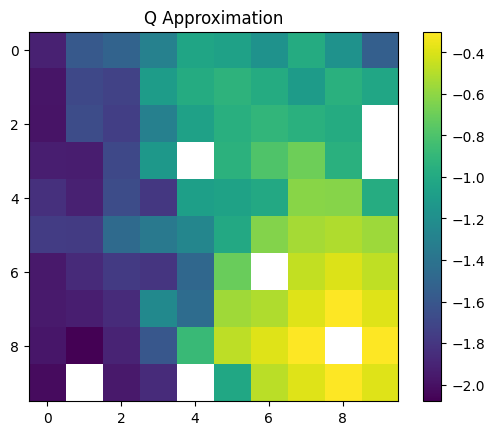

|→|→|→|→|↓|→|↓|↓|↓|↓|
|→|↑|↑|→|→|↓|↓|→|↓|←|
|↓|↑|→|→|→|→|↓|↓|←|█|
|↓|→|↑|↑|█|↑|→|↓|↑|█|
|↓|→|→|↓|→|↑|→|↓|↓|←|
|→|→|→|→|→|↑|→|↓|↓|↓|
|↑|↓|↑|→|→|↓|█|↓|↓|←|
|↓|↑|↓|→|↓|→|→|→|↓|←|
|↑|↑|→|↑|→|→|→|→|█|←|
|↑|█|↑|↑|█|→|↑|↑|↑|←|


In [37]:
height = 10
width = 10
num_episodes = 5000
g = GridWorld(height, width, complex=True, win_state=State(height-2, width-2), num_walls=3, num_warps=3)
print(g) # print the gridworld
random.seed(0)
Q, episode_returns, wallclock_times, Q_sa_pair = approximate_q(g, ArgMaxAgent(), approximator=Sarsa_Approximator, num_episodes=num_episodes, track=True)

# plot maximum Q values
(q_values, actions) = max_q(Q)
plt.imshow(q_values)
plt.colorbar()
plt.title("Q Approximation")
plt.show()

print_policy_from_q(Q)

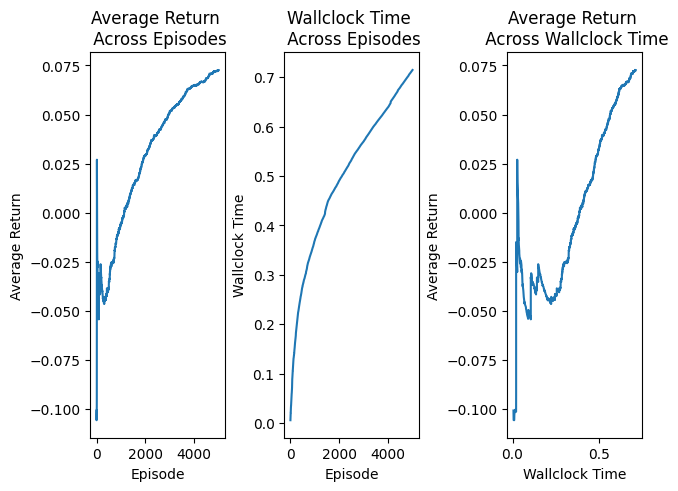

In [6]:
fig, axs = plt.subplots(1,3,layout='constrained')
# plot of average return per episode

avg_returns_by_episode = []

# calculate avg returns by episode, which is the average return for different
# sized 'bins' (examples: ep1, ep1-10, ep1-100) 
for i in range(1, len(episode_returns)+1):
    avg_returns_by_episode.append(average(episode_returns[:i]))

axs[0].title.set_text('Average Return \n Across Episodes')
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Average Return")
axs[0].plot(range(num_episodes), avg_returns_by_episode)

axs[1].title.set_text('Wallclock Time \n Across Episodes')
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Wallclock Time")
axs[1].plot(range(num_episodes), wallclock_times)

axs[2].title.set_text('Average Return \n Across Wallclock Time')
axs[2].set_xlabel("Wallclock Time")
axs[2].set_ylabel("Average Return")
axs[2].plot(wallclock_times, avg_returns_by_episode)

plt.show()

### 3 Visualizing Variance-Bias Trade-Off
Pick some average return, which constitures roughly the half-way-point between your algorithms average starting return and fully trained return. For both MC- control (from last weeks homework) and 1-step SARSA, do the following: (pick the same state for both!)
* For both SARSA and MC-Control:
    - Sample 1000 or more episodes starting at some specific (e.g. the starting) state, with some specific action
    - Update only this specific starting Q-value!
    - Track how the Q-value changes over the episodes (i.e. provide a list or ndarray with an estimation aver each episode)
* Repeat the above 100 (or more) times for both SARSA and MC-Control 2
* For both SARSA and MC-Control, create a lineplot including mean and std estimation (over the 100+ repeats) vs. episodes sampled
* Interpret the result

In [28]:
import numpy as np

height = 10
width = 10
num_episodes = 10000
g = GridWorld(height, width, complex=True, win_state=State(height-2, width-2), num_walls=3, num_warps=3)
print(g) # print the gridworld
random.seed(0)

num_samples = 100
mc_samples = np.zeros((num_samples, num_episodes))
sarsa_samples = np.zeros((num_samples, num_episodes))

for s in range(num_samples):
    
    random.seed(0)
    Q_mc, episode_returns_mc, wallclock_times_mc, Q_sa_pair_mc = approximate_q(g, ArgMaxAgent(), approximator=MC_Approximator, num_episodes=num_episodes, fix_starting_state_action_pair=True)
    random.seed(0)
    Q_sarsa, episode_returns_sarsa, wallclock_times_sarsa, Q_sa_pair_sarsa = approximate_q(g, ArgMaxAgent(), approximator=Sarsa_Approximator, num_episodes=num_episodes, fix_starting_state_action_pair=True)
    
    mc_samples[s,:] = Q_sa_pair_mc
    sarsa_samples[s,:] = Q_sa_pair_sarsa
    
    if s%10 == 0:
        print(s, " samples completed.")

#mc_by_episode = np.zeros((num_episodes, 2)) # 0 means, 1 stds
#sarsa_by_episode = np.zeros((num_episodes, 2))


mc_means_by_episode = np.mean(mc_samples, axis=0)
mc_stds_by_episode = np.std(mc_samples, axis=0)
sarsa_means_by_episode = np.mean(sarsa_samples, axis=0)
sarsa_stds_by_episode = np.std(sarsa_samples, axis=0)

    

"""Q_mc, episode_returns_mc, wallclock_times_mc, Q_sa_pair_mc = approximate_q(g, ArgMaxAgent(), approximator=MC_Approximator, num_episodes=num_episodes, fix_starting_state_action_pair=True)
axs[0].title.set_text('Monte Carlo Estimation')
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Q value")
axs[0].plot(range(num_episodes), Q_sa_pair_mc)

random.seed(0)
Q_sarsa, episode_returns_sarsa, wallclock_times_sarsa, Q_sa_pair_sarsa = approximate_q(g, ArgMaxAgent(), approximator=Sarsa_Approximator, num_episodes=num_episodes, fix_starting_state_action_pair=True)
axs[1].title.set_text('1-step SARSA Estimation')
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Q value")
axs[1].plot(range(num_episodes), Q_sa_pair_sarsa)"""



| | | | | | | | | | |
| | | | | | | | | | |
| | | | | | | | | |█|
| | | | |*| | | | |█|
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | | |█| | | |
| | | | | | | | | | |
| | | | | | | | |W| |
| |*| | |*| | | | | |
0  samples completed.
10  samples completed.
20  samples completed.
30  samples completed.
40  samples completed.
50  samples completed.
60  samples completed.
70  samples completed.
80  samples completed.
90  samples completed.


'Q_mc, episode_returns_mc, wallclock_times_mc, Q_sa_pair_mc = approximate_q(g, ArgMaxAgent(), approximator=MC_Approximator, num_episodes=num_episodes, fix_starting_state_action_pair=True)\naxs[0].title.set_text(\'Monte Carlo Estimation\')\naxs[0].set_xlabel("Episode")\naxs[0].set_ylabel("Q value")\naxs[0].plot(range(num_episodes), Q_sa_pair_mc)\n\nrandom.seed(0)\nQ_sarsa, episode_returns_sarsa, wallclock_times_sarsa, Q_sa_pair_sarsa = approximate_q(g, ArgMaxAgent(), approximator=Sarsa_Approximator, num_episodes=num_episodes, fix_starting_state_action_pair=True)\naxs[1].title.set_text(\'1-step SARSA Estimation\')\naxs[1].set_xlabel("Episode")\naxs[1].set_ylabel("Q value")\naxs[1].plot(range(num_episodes), Q_sa_pair_sarsa)'

(0.0, 0.25)

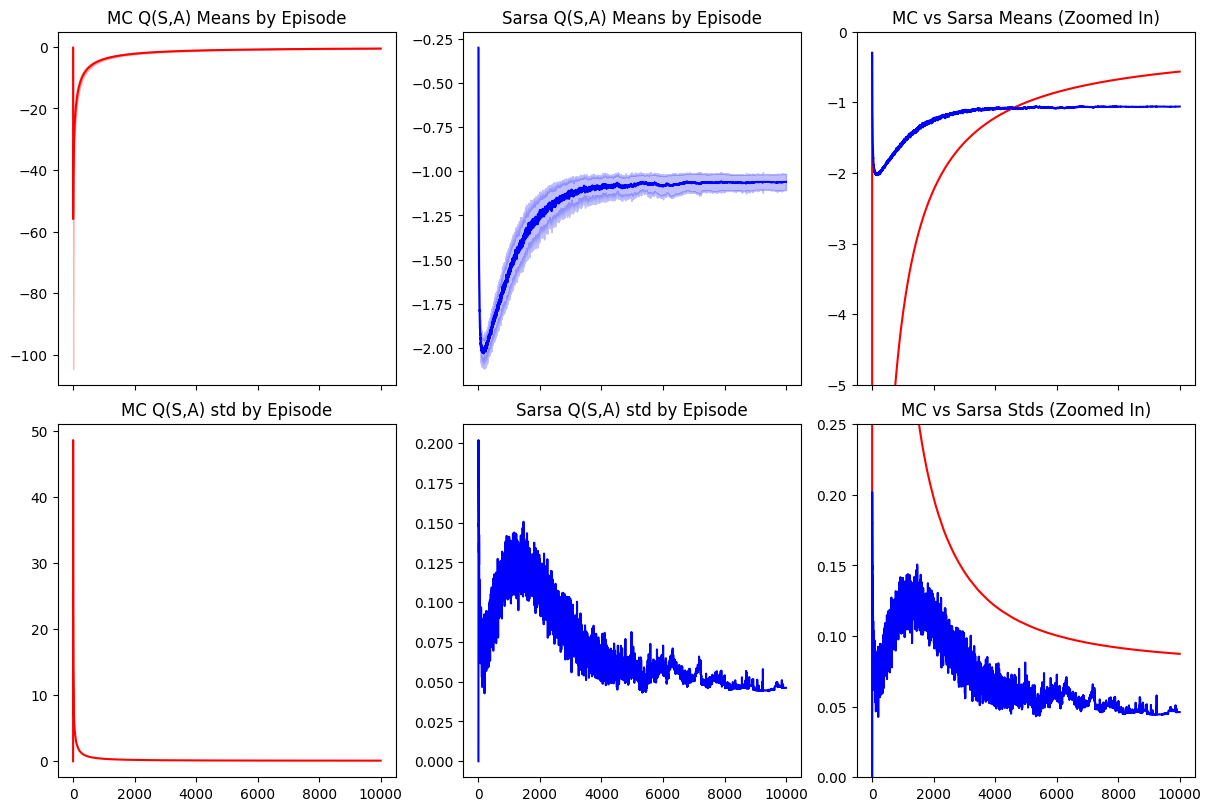

In [29]:
""" plots the mean return (first row) and mean std (second row) for each episode """
fig, axs = plt.subplots(2,3,layout='constrained',sharex=True, figsize=(12,8))

axs[0,0].plot(np.arange(num_episodes), mc_means_by_episode, color = 'red')
axs[0,0].fill_between(np.arange(num_episodes), mc_means_by_episode - mc_stds_by_episode, 
                      mc_means_by_episode + mc_stds_by_episode, 
                      color = 'red', alpha=0.25) 
axs[0,0].set_title("MC Q(S,A) Means by Episode")

axs[0,1].plot(np.arange(num_episodes), sarsa_means_by_episode, color = 'blue')
axs[0,1].fill_between(np.arange(num_episodes), sarsa_means_by_episode - sarsa_stds_by_episode, 
                      sarsa_means_by_episode + sarsa_stds_by_episode, 
                      color = 'blue', alpha=0.25) 
axs[0,1].set_title("Sarsa Q(S,A) Means by Episode")

axs[1,0].plot(np.arange(num_episodes), mc_stds_by_episode, color = 'red')
axs[1,0].set_title("MC Q(S,A) std by Episode")
axs[1,1].plot(np.arange(num_episodes), sarsa_stds_by_episode, color = 'blue')
axs[1,1].set_title("Sarsa Q(S,A) std by Episode")

axs[0,2].plot(np.arange(num_episodes), mc_means_by_episode, color = 'red')
axs[0,2].plot(np.arange(num_episodes), sarsa_means_by_episode, color = 'blue')
axs[0,2].set_title("MC vs Sarsa Means (Zoomed In)")

axs[1,2].plot(np.arange(num_episodes), mc_stds_by_episode, color = 'red')
axs[1,2].plot(np.arange(num_episodes), sarsa_stds_by_episode, color = 'blue')

axs[1,2].set_title("MC vs Sarsa Stds (Zoomed In)")

axs[0,2].set_ylim(-5,0)
axs[1,2].set_ylim(0,0.25)

Variance-Bias Tradeoff
----
To evaluate the variance-bias trade-off for our implementations of MC estimation and 1-step Sarsa, we chose a fixed initial S,A pair of ((0,4), DOWN). Since our grid is quite large, we chose to run 100 samples of 10,000 episodes to compute the expected return and standard deviation of return for each episode of training. 

The above plot displays the mean Q(S,A) value for MC estimation and Sarsa Q approximation, as well as the mean std of values for Q(S,A), across samples. Shaded regions in the plot of the means represent +/- one standard deviation from the mean. The y-scale for the MC and Sarsa approximation plots are orders of magnitude different, so we also included a 'zoomed in' version of the means for each method overalyed, as well as the standard deviations, to more easily compare the final episodes of the two methods. 

We first notice that the mean returns for Sarsa appear to change less over episodes compared to MC estimation, indicating a smaller variance. However, since MC estimation, given enough training, provides a good estimate of the true Q value for the S,A pair, we can see that the Sarsa method produces a bias where it underestimates the q value. 

In [ ]:
TO DO
----